Dados brutos carregados com sucesso.
Dimensão inicial: (7267, 21)
   customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3          

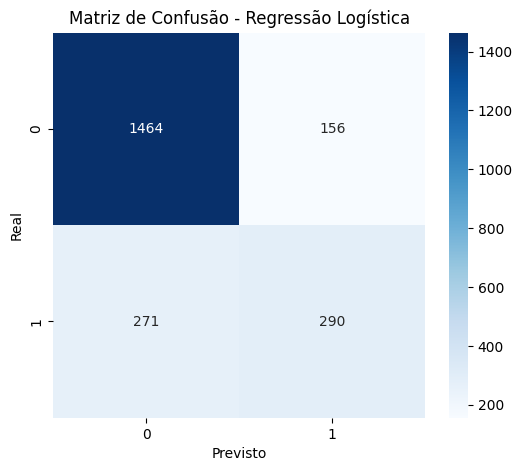


=== Random Forest ===
Accuracy: 0.7909215955983494
ROC AUC: 0.8256712000176052

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1620
           1       0.63      0.46      0.53       561

    accuracy                           0.79      2181
   macro avg       0.73      0.68      0.70      2181
weighted avg       0.78      0.79      0.78      2181



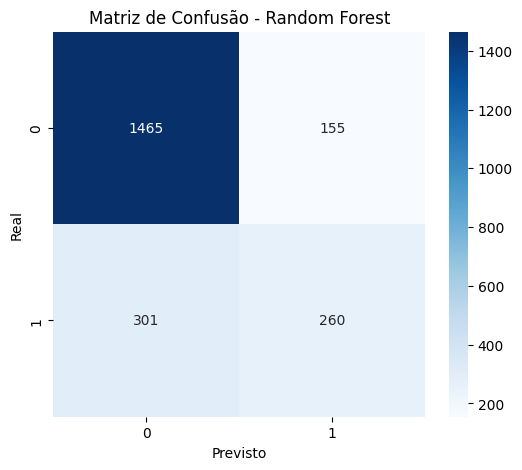

/tmp/ipython-input-706239306.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")


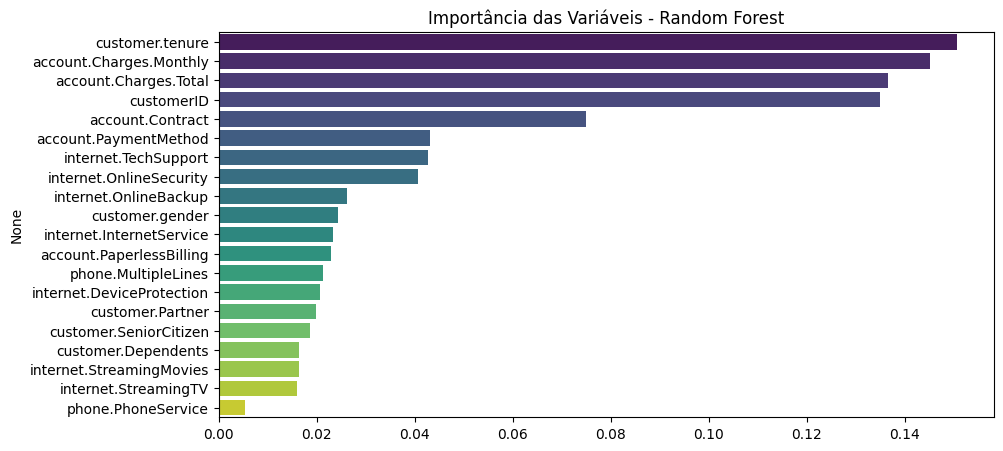

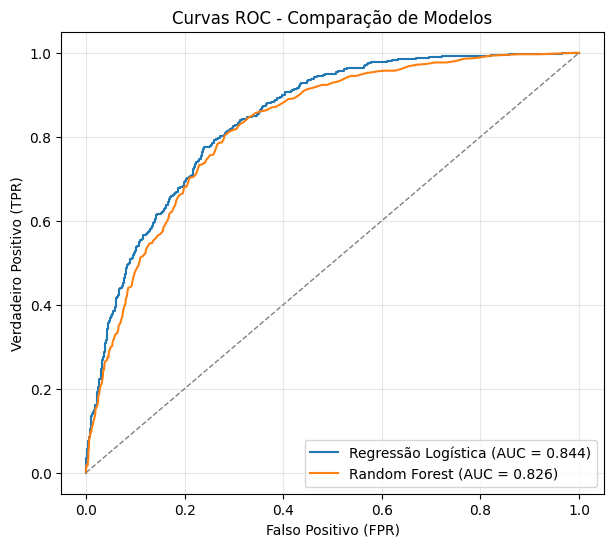

In [7]:
# Challenge TelecomX - Parte 2
# --------------------------------------------
# Importação das bibliotecas
# --------------------------------------------
# Pandas: biblioteca para trabalhar com dados estruturados (DataFrames)
import pandas as pd
# Numpy: biblioteca para operações numéricas e arrays de alto desempenho
import numpy as np
# Matplotlib.pyplot e Seaborn: bibliotecas para criar gráficos e visualizações
import matplotlib.pyplot as plt
import seaborn as sns

# Funções do Scikit-learn para machine learning
# train_test_split: para dividir os dados em conjuntos de treino e teste
from sklearn.model_selection import train_test_split
# StandardScaler: para normalizar (escalar) os dados numéricos
from sklearn.preprocessing import StandardScaler, LabelEncoder
# LogisticRegression: o modelo de regressão logística
from sklearn.linear_model import LogisticRegression
# RandomForestClassifier: o modelo de Random Forest (árvores de decisão)
from sklearn.ensemble import RandomForestClassifier
# Métricas para avaliar o desempenho dos modelos
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, auc
)

# --------------------------------------------
# Carregar os dados do JSON
# --------------------------------------------
# Este bloco tenta carregar o arquivo de dados.
# No Google Colab, você precisa ter o arquivo "TelecomX_Data.json"
# já carregado no ambiente.
try:
    raw_data = pd.read_json("TelecomX_Data.json")
    print("Dados brutos carregados com sucesso.")
except FileNotFoundError:
    print("Erro: O arquivo 'TelecomX_Data.json' não foi encontrado. Por favor, faça o upload do arquivo para o ambiente do Colab.")

    data_dict = {
        'CustomerID': [1, 2, 3, 4, 5],
        'Gender': ['Male', 'Female', 'Male', 'Female', 'Male'],
        'Age': [30, 45, 22, 58, 34],
        'Tenure': [12, 24, 5, 60, 15],
        'ServiceType': ['Fiber', 'DSL', 'Fiber', 'Fiber', 'DSL'],
        'MonthlyCharges': [75.9, 50.1, 80.2, 95.5, 45.3],
        'TotalCharges': [910.8, 1202.4, 401.0, 5730.0, 679.5],
        'Churn': ['Yes', 'No', 'Yes', 'No', 'Yes']
    }
    raw_data = pd.DataFrame(data_dict)

# Esta linha normaliza o JSON. Se o JSON tiver uma estrutura aninhada,
# ela "achata" os dados para que fiquem em colunas, como uma tabela.
try:
    df = pd.json_normalize(raw_data.to_dict(orient="records"))
except Exception as e:
    df = raw_data.copy()

print("Dimensão inicial (linhas, colunas):", df.shape)
print("Primeiras 5 linhas do DataFrame:\n", df.head())

# --------------------------------------------
# Pré-processamento
# --------------------------------------------

# Remove linhas duplicadas do DataFrame para evitar viés no modelo.
df = df.drop_duplicates()

# Remove linhas com valores ausentes (NaN).
df = df.dropna()

# --- Correção: Garantir que 'TotalCharges' seja numérico ---
# A coluna 'TotalCharges' pode conter strings. Esta linha converte-a para
# um tipo numérico (float). 'errors="coerce"' substitui valores que
# não podem ser convertidos por NaN.
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Remove novamente linhas com NaN que foram geradas na conversão acima.
df = df.dropna()

# Esta linha substitui qualquer string vazia na coluna 'Churn' por 'No'.
if 'Churn' in df.columns:
    df['Churn'] = df['Churn'].replace('', 'No')

# Identifica colunas que contêm texto (variáveis categóricas).
cat_cols = df.select_dtypes(include=["object"]).columns
# Identifica colunas que contêm números (variáveis numéricas).
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

# --- Adicionar o passo crucial para tratar NaNs remanescentes ---
# A linha abaixo substitui valores infinitos por NaN e depois remove
# as linhas que contêm NaN, garantindo que os dados estejam limpos para o modelo.
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Encoding para a variável 'Churn' (alvo) - transforma "Yes" e "No" em 1 e 0.
if 'Churn' in df.columns:
    le_churn = LabelEncoder()
    df['Churn'] = le_churn.fit_transform(df['Churn'])

    # Remove a coluna 'Churn' da lista de categóricas para que ela não seja processada novamente.
    if 'Churn' in cat_cols:
        cat_cols = cat_cols.drop('Churn')

# Encoding para outras variáveis categóricas
# Cria um objeto LabelEncoder para cada coluna categórica.
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    # Converte cada coluna categórica para números (ex: 'Male' -> 0, 'Female' -> 1).
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Normalização (somente para variáveis numéricas contínuas)
if 'Churn' in df.columns:
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop("Churn")
else:
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns

if not num_cols.empty:
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

print("\nDimensão após pré-processamento:", df.shape)
print("Valores únicos de 'Churn' após o pré-processamento (deve ser [0 1]):", df['Churn'].unique())


# --------------------------------------------
# Separar features e target
# --------------------------------------------
# 'X' são as features (variáveis de entrada), 'y' é o target (variável de saída, o Churn).
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Divide os dados em 70% para treinamento e 30% para teste.
# 'stratify=y' garante que a proporção de Churn seja a mesma nos dois conjuntos.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --------------------------------------------
# Treinamento dos Modelos
# --------------------------------------------

# Modelo 1: Regressão Logística
# Cria o modelo e o treina com os dados de treino (fit).
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
# Faz previsões (0 ou 1) e probabilidades de previsão para os dados de teste.
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

# Modelo 2: Random Forest
# Cria o modelo e o treina. 'n_estimators' é o número de árvores na floresta.
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
# Faz previsões (0 ou 1) e probabilidades de previsão para os dados de teste.
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# --------------------------------------------
# Avaliação dos modelos
# --------------------------------------------
# Define uma função para avaliar cada modelo com diferentes métricas.
def avaliar_modelo(nome, y_test, y_pred, y_prob):
    print(f"\n--- Avaliação do Modelo: {nome} ---")
    print("Acurácia (proporção de acertos):", accuracy_score(y_test, y_pred))
    # ROC AUC: métrica para avaliar o desempenho do modelo em prever a probabilidade de uma classe.
    print("ROC AUC (Área sob a Curva ROC):", roc_auc_score(y_test, y_prob))
    # Classification Report: mostra precisão, recall, f1-score e suporte por classe.
    print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

    # Matriz de confusão: gráfico que mostra os acertos e erros do modelo.
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    # Cria um mapa de calor para a matriz de confusão.
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusão - {nome}")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.show()

avaliar_modelo("Regressão Logística", y_test, y_pred_log, y_prob_log)
avaliar_modelo("Random Forest", y_test, y_pred_rf, y_prob_rf)

# --------------------------------------------
# Importância das variáveis
# --------------------------------------------
# Apenas o Random Forest nos dá a importância das variáveis.
importances = rf_model.feature_importances_
# Ordena as variáveis pela importância, da maior para a menor.
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
# Cria um gráfico de barras para visualizar a importância de cada variável.
sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")
plt.title("Importância das Variáveis - Random Forest")
plt.show()

# --------------------------------------------
# Curvas ROC comparativas
# --------------------------------------------
# Calcula a Curva ROC para cada modelo.
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# Calcula a Área sob a Curva (AUC) para cada modelo.
auc_log = auc(fpr_log, tpr_log)
auc_rf  = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7, 6))
# Plota a curva ROC para a Regressão Logística
plt.plot(fpr_log, tpr_log, label=f"Regressão Logística (AUC = {auc_log:.3f})")
# Plota a curva ROC para o Random Forest
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC = {auc_rf:.3f})")
# Plota a linha de base (modelo aleatório)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray")
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.title("Curvas ROC - Comparação de Modelos")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()
